# WSI 24L
## Ćwiczenie 5 - sztuczne sieci neuronowe
### Igor Szabłowski

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

## Implementacja

Zaimplementowany został perceptron wielowarstwowy z algorytmem optymalizacji metodą gradientu prostego oraz algorytmem propagacji wstecznej. Implementacja sieci została podzielona na dwie klasy: Layer oraz NeuralNetwork. Layer jest klasą pomocniczą do NeuralNetwork. Przez użytkownika podawane są jako argumenty: wielkości warstw, funkcja aktywacji, pochodna funkcji aktywacji oraz funkcja straty.

In [11]:
class Layer:
    def __init__(self, input_count, output_count):
        self.weights = np.random.rand(input_count, output_count) / np.sqrt(input_count)
        self.biases = np.random.rand(1, output_count)
        self.input = None
        self.output = None

    def activate(self, input, activation_fun):
        self.input = input
        self.output = activation_fun(np.dot(input, self.weights) + self.biases)
        return self.output

    def update_weights(self, delta, previous_output, learning_rate):
        self.weights += learning_rate * np.dot(previous_output.T, delta) / len(previous_output)
        self.biases += learning_rate * np.mean(delta, axis=0)

class NeuralNetwork:
    def __init__(self, layers, activation_fun, activation_derivative_fun, loss_fun):
        self._loss_fun = loss_fun
        self._activation_fun = activation_fun
        self._activation_derivative_fun = activation_derivative_fun
        self._layers_size = layers
        self._layers = [Layer(layers[i], layers[i+1]) for i in range(len(layers)-1)]

    def _feed_forward(self, input):
        output = [np.array(input)]
        for layer in self._layers:
            output.append(layer.activate(output[-1], self._activation_fun))
        return output

    def calculate_loss(self, y, y_mod):
        return self._loss_fun(y, y_mod)

    def _back_propagation(self, input, output, learning_rate):
        neurons_outputs = self._feed_forward(input)
        if self._layers_size[-1] == 1:
            error = np.array(output).reshape(-1, 1) - neurons_outputs[-1]
        else:
            error = np.eye(self._layers_size[-1])[output] - neurons_outputs[-1]
        
        delta = error * self._activation_derivative_fun(neurons_outputs[-1])
        self._layers[-1].update_weights(delta, neurons_outputs[-2], learning_rate)

        for i in reversed(range(len(self._layers)-1)):
            delta = np.dot(delta, self._layers[i+1].weights.T) * self._activation_derivative_fun(neurons_outputs[i+1])
            self._layers[i].update_weights(delta, neurons_outputs[i], learning_rate)

    def train(self, input, output, epochs, learning_rate):
        for _ in range(epochs):
            self._back_propagation(input, output, learning_rate)

    def predict(self, input):
        network_output = self._feed_forward(input)[-1]
        if self._layers_size[-1] == 1:
            return np.round(network_output).astype(int)
        else:
            return np.argmax(network_output, axis=1)


Do poniżej wykonanych testów, jako funkcja aktywacji używana była funkcja `sigmoid`, a jako funkcja straty `mse` (Mean squared error).

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def mse(y, y_mod):
    return np.mean(np.power((y-y_mod), 2))


Dobieranie parametrów oraz testy są przeprowadzane na zbiorze danych MNIST (ręcznie pisane cyfry). Pobrany zbiór został podzielony na trzy podzbiory: trenujący, walidacyjny i testowy. Wszystkie eksperymenty z różnymi parametrami zostaną wykonane na zbiorze walidacyjnym, a każda z sieci będzie trenowana zbiorem trenującym. Dane należało przekształcić do postaci wektorów. Aby użyć danej implementacji sieci neuronowej, należy na stworzonym obiekcie wywołać metodę `train`, podając dane oraz wyjścia trenujące, współczynnik uczenia, oraz ilość epok (epochs) przez które sieć ma się uczyć. Następnie aby uzyskać predykcje sieci należy wywołać metodę `predict`, podając dane do których mają zostać znalezione wyjścia. Poniżej przedstawione jest przykładowe użycie tej implementacji.

In [4]:
digits = load_digits()

X_digits, y_digits = digits.data, digits.target

X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=1, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=1, test_size=0.2)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

learning_rate = 2
epochs = 10000
layer_sizes = [X_digits.shape[1], 20, 10]

network = NeuralNetwork(layer_sizes, sigmoid, sigmoid_derivative, mse)
network.train(X_train, y_train, epochs, learning_rate)
predictions = network.predict(X_val)
print(accuracy_score(y_val, predictions))

0.9201388888888888


Pierwszym eksperymentem jest zbadanie wpływu ilości neuronów w wartswie ukrytej dla sieci z jedną warstwą ukrytą. Badaniu zostały poddane sieci z wielkościami wartswy ukrytej z przedziału od 1 do 100. Jak można zauważyć każda kolejna większa ilość neuronów przynosiła większą dokładność oraz mniejszą stratę. Zauważyć też można, że zmiana ta nie jest liniowa. Od pewnej ilości neuronów zmiany nie są już aż tak widoczne.

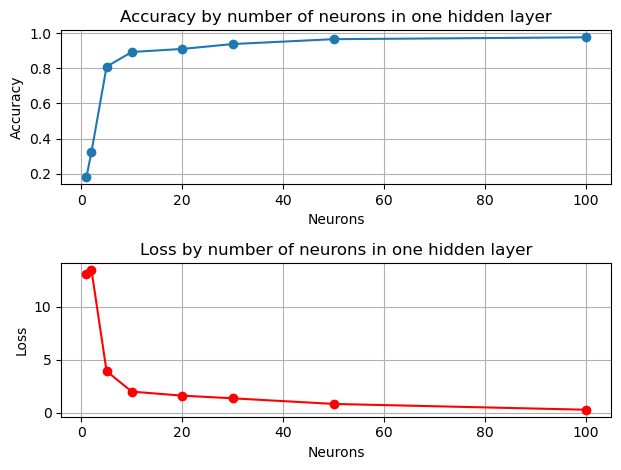

In [5]:
learning_rate = 2
epochs = 10000
neurons_in_hidden_layer = [1, 2, 5, 10, 20, 30, 50, 100]
accuracies = []
losses = []

for neurons in neurons_in_hidden_layer:
    layer_sizes = [X_digits.shape[1], neurons, 10]
    network = NeuralNetwork(layer_sizes, sigmoid, sigmoid_derivative, mse)
    network.train(X_train, y_train, epochs, learning_rate)
    predictions = network.predict(X_val)
    accuracy = accuracy_score(y_val, predictions)
    loss = network.calculate_loss(y_val, predictions)
    accuracies.append(accuracy)
    losses.append(loss)

plt.subplot(2, 1, 1)
plt.plot(neurons_in_hidden_layer, accuracies, marker='o')
plt.title(f'Accuracy by number of neurons in one hidden layer')
plt.xlabel('Neurons')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(neurons_in_hidden_layer, losses, marker='o', color='r')
plt.title(f'Loss by number of neurons in one hidden layer')
plt.xlabel('Neurons')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

Poniżej zostały zbadane zależność dokładności oraz straty od współczynnika uczenia. Jak można zauważyć, wszystkie sieci ze współczynnikami uczenia z przedziału od 0.1 do 5 dały zadowalający wynik. Możliwym powodem takiego wyniku jest relatywnie niewielka ilość neuronów (20 neuronów, 1 warstwa ukryta) i wystarczająca ilość epok, aby sieci te zostały wytrenowane mimo takiej rozbieżności współczynników uczenia.

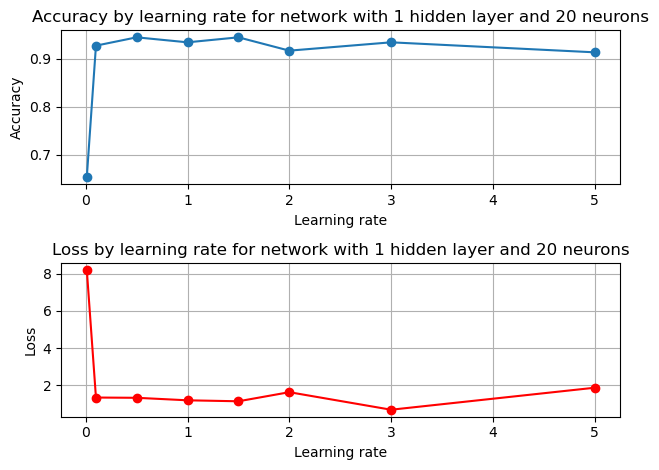

In [6]:
epochs = 5000
neurons_in_hidden_layer = 20
learning_rates = [0.01, 0.1, 0.5, 1, 1.5, 2, 3, 5]
accuracies = []
losses = []

for learning_rate in learning_rates:
    layer_sizes = [X_train.shape[1], neurons_in_hidden_layer, 10]
    network = NeuralNetwork(layer_sizes, sigmoid, sigmoid_derivative, mse)
    network.train(X_train, y_train, epochs, learning_rate)
    predictions = network.predict(X_val)
    accuracy = accuracy_score(y_val, predictions)
    loss = network.calculate_loss(y_val, predictions)
    accuracies.append(accuracy)
    losses.append(loss)

plt.subplot(2, 1, 1)
plt.plot(learning_rates, accuracies, marker='o')
plt.title(f'Accuracy by learning rate for network with 1 hidden layer and 20 neurons')
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(learning_rates, losses, marker='o', color='r')
plt.title(f'Loss by learning rate for network with 1 hidden layer and 20 neurons')
plt.xlabel('Learning rate')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

Sieć z taką samą konfiguracją jak w poprzednim eksperymencie (20 neuronów, 1 warstwa ukryta), tym razem ze stałym współczynnikiem uczenia równym 2, została przetestowana na tle zmiany ilości epok przez które może się uczyć. Najlepiej poradziły sobie sieci trenowane przez ilości epok od 500 do 5000. Te uczone przez mniejszą ilość epok nie zdążyły się wyuczyć, natomiast te uczone przez większą ilość epok niż 5000 utrzymały stabilny wynik dokładności w okolicach 90% oraz straty w okolicach 2.

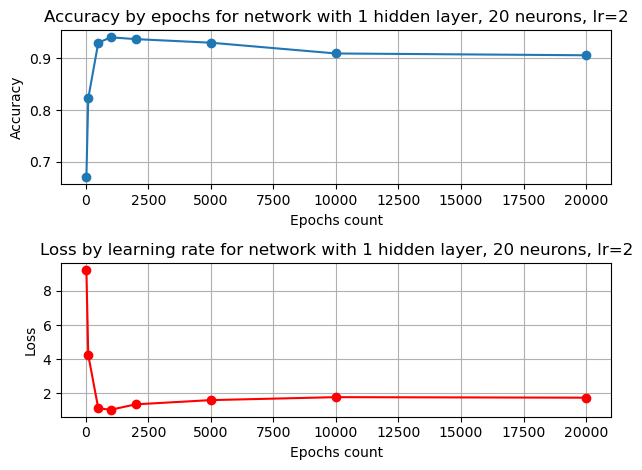

In [7]:
epochs_set = [25, 100, 500, 1000, 2000, 5000, 10000, 20000]
neurons_in_hidden_layer = 20
learning_rate = 2
accuracies = []
losses = []

for epochs in epochs_set:
    layer_sizes = [X_train.shape[1], neurons_in_hidden_layer, 10]
    network = NeuralNetwork(layer_sizes, sigmoid, sigmoid_derivative, mse)
    network.train(X_train, y_train, epochs, learning_rate)
    predictions = network.predict(X_val)
    accuracy = accuracy_score(y_val, predictions)
    loss = network.calculate_loss(y_val, predictions)
    accuracies.append(accuracy)
    losses.append(loss)

plt.subplot(2, 1, 1)
plt.plot(epochs_set, accuracies, marker='o')
plt.title(f'Accuracy by epochs for network with 1 hidden layer, 20 neurons, lr=2')
plt.xlabel('Epochs count')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(epochs_set, losses, marker='o', color='r')
plt.title(f'Loss by learning rate for network with 1 hidden layer, 20 neurons, lr=2')
plt.xlabel('Epochs count')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

W poniższym teście sieci zostały przebadane względem ilości neuronów oraz ilości warstw ukrytych. Założeniem testu były ilości neuronów będące mniejszą potęgą dwójki w każdej kolejnej warstwie, dla różnych ilości warstw ukrytych. Jak można zauważyć sieci z jedną oraz dwiema warstwami poradziły sobie dobrze, dały zadowalające wyniki. Sieci z trzema oraz czterema warstwami ukrytymi dały natomiast relatywnie słabe wyniki. Każda z sieci została przetestowana w identycznych warunkach poza wielkościami neuronów. Oznacza to, że niezadowalający wynik może być spowodowany zbyt małą ilością epok przez które sieci się uczyły, bądź źle dobranym do wielkości sieci współczynnikiem uczenia.

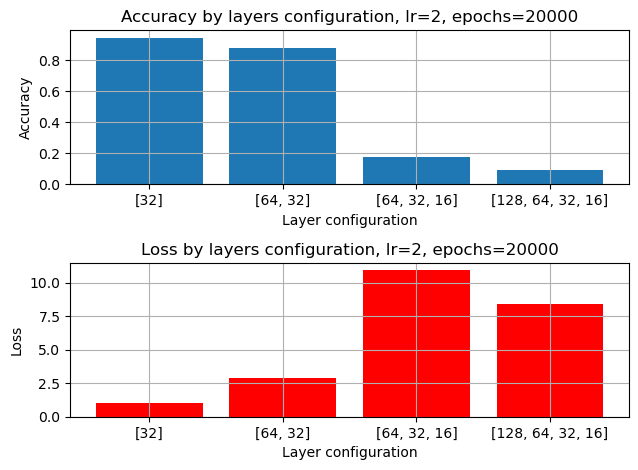

In [8]:
epochs = 20000
learning_rate = 2
layer_sizes_set = [[32], [64, 32], [64, 32, 16], [128, 64, 32, 16]]
accuracies = []
losses = []

for sizes in layer_sizes_set:
    layer_sizes = sizes.copy()
    layer_sizes.insert(0, X_train.shape[1])
    layer_sizes.append(10)
    network = NeuralNetwork(layer_sizes, sigmoid, sigmoid_derivative, mse)
    network.train(X_train, y_train, epochs, learning_rate)
    predictions = network.predict(X_val)
    accuracy = accuracy_score(y_val, predictions)
    loss = network.calculate_loss(y_val, predictions)
    accuracies.append(accuracy)
    losses.append(loss)

layer_sizes_set = [str(size) for size in layer_sizes_set]

plt.subplot(2, 1, 1)
plt.bar(layer_sizes_set, accuracies)
plt.title(f'Accuracy by layers configuration, lr=2, epochs=20000')
plt.xlabel('Layer configuration')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.bar(layer_sizes_set, losses, color='r')
plt.title(f'Loss by layers configuration, lr=2, epochs=20000')
plt.xlabel('Layer configuration')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

Ostateczny test przeprowadzony został na danych testowych. Jako parametry i konfiguracje ostatecznej sieci przyjęte zostały parametry z próby względem epokami, które dały najlepszy wynik spośród przeprowadzonych eksperymentów. Jak można zauważyć, dla danych testowych, sieć dała bardzo zadowalający wynik wynoszący w przybliżeniu 94% dokładności oraz 0.73 straty.

In [17]:
epochs = 1000
learning_rate = 2

network = NeuralNetwork([X_train.shape[1], 20, 10], sigmoid, sigmoid_derivative, mse)
network.train(X_train, y_train, epochs, learning_rate)
predictions = network.predict(X_test)
loss = network.calculate_loss(y_test, predictions)
print(f'Accuracy: {accuracy_score(y_test, predictions)}')
print(f'Loss: {loss}')

Accuracy: 0.9416666666666667
Loss: 0.725


### Wnioski
Sztuczne sieci neuronowe z dobrymi parametrami dają zadowalające wyniki już dla jednej warstwy ukrytej, a nie zawsze dołożenie kolejnych będzie się równać poprawieniu tego wyniku. Należy ocenić ile czasu (epok), jest się w stanie przekazać na trenowanie sieci, i także względem tego dobierać jej wielkości. Należy także zwrócić uwagę na wielkości danych wejściowych oraz wyjściowych, aby sieć nie miała zbyt małej ilości neuronów względem tych wielkości.